In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal,norm
from scipy import optimize 
import math
import pandas as pd

We first need generate some 'true' data. We use the  $\theta_{11} = 400$ and  $\theta_{12} = 5000$ as true parameter  $\theta$

In [2]:
def generate_obs_y_i(theta,d,sigma):
    '''
    This function is used to generated the observation data, y
    input:
        m:   the number of model
        n:   the number of run
        d:   the design point
    output:
        obs_y: the data drawn from the 'true' distribution
    '''
    
    obs_y = []
    
    for i in range(n):
        # obtain the parameter
        xi_m = np.exp(-theta[0] * d[i][0] * np.exp(-theta[1]/d[i][1]))
        
        y_i = np.random.normal(xi_m,sigma)
        obs_y.append(y_i)
    
    return obs_y

In [3]:
theta = [400,5000]
sigma = 0.1

n = 50
d = []
for i in range(n):
    x_i1 = random.random()*150
    x_i2 = random.random()*150 + 450
    d.append([x_i1,x_i2])

d = np.array(d)
    
y_m1 = generate_obs_y_i(theta,d,sigma)

Text(0, 0.5, '$y_{m1}$')

<Figure size 432x288 with 0 Axes>

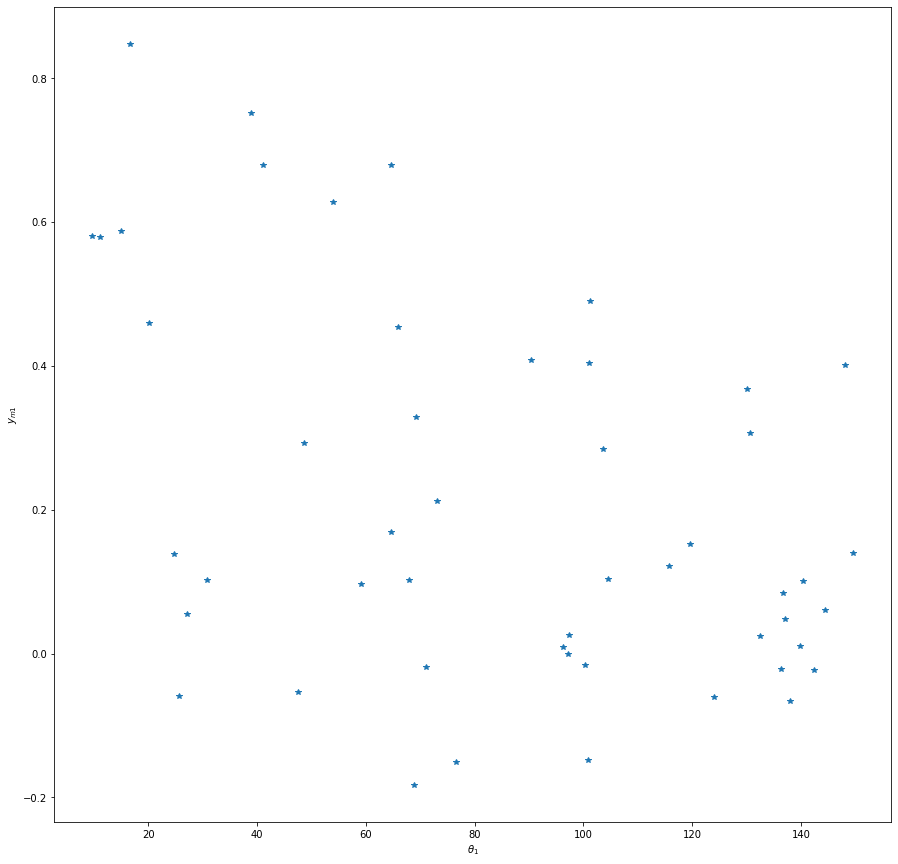

In [4]:
fig = plt.figure()
plt.figure(figsize=(15,15))
plt.plot(d[:,0],y_m1,'*')
plt.xlabel(r"${\theta}_1$")
plt.ylabel("$y_{m1}$")


Text(0, 0.5, '$y_{m1}$')

<Figure size 432x288 with 0 Axes>

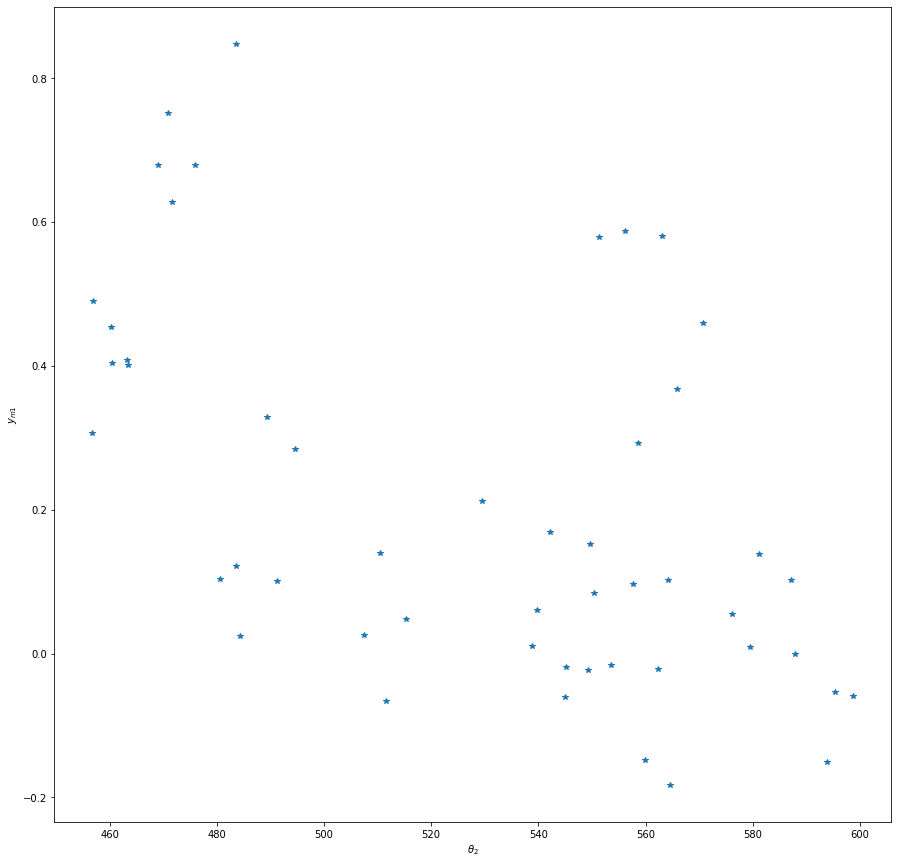

In [5]:
fig1 = plt.figure()
plt.figure(figsize=(15,15))

plt.plot(d[:,1],y_m1,'*')
plt.xlabel(r"${\theta}_2$")
plt.ylabel("$y_{m1}$")


Next, we need to find the posterior distribution. First we let <br>
<center>$p(\theta|y) = kp(y|\theta)p(\theta) \tag{1}$</center><br>
where we let $k=1$ as the normalize constant just for convience. The likelihood function is $p(y|\theta)$ and prior is
$p(\theta)$ = obs_data.<br><br>

First, we know that $y_i$ is i.i.d and $y_i$ ~ $N(\eta_m(\theta;d_i),\sigma^2)$. Hence we can have likelihood function as<br>

$$
\begin{align}
l(\theta) =& N(y_1;\eta_m(\theta;d_i),\sigma^2) \times N(y_1;\eta_m(\theta;d_i),\sigma^2) \times ... \times N(y_n;\eta_m(\theta;d_i),\sigma^2) \\
          =& \prod_{i=0}^n N(y_i;\eta_m(\theta;d_i),\sigma^2) \tag{2}
\end{align}
$$<br>

Hence, the log-likelihood fucntion is <br>
$$
\begin{align}
L(\theta) =& log(\prod_{i=0}^n N(y_i;\eta_m(\theta;d_i),\sigma^2)) \\
          =& \sum_{i=1}^n log(N(y_i;\eta_m(\theta;d_i),\sigma^2)) \tag{3}
\end{align}
$$<br>

Then we can rewrite $\tag{1}$ as
$$
\begin{align}
p(\theta|y) =& kp(y|\theta)p(\theta) \\
            =& log(p(y|\theta)p(\theta))\\
            =& log(p(y|\theta)) + log(p(\theta))\\
            =& \sum_{i=1}^n log(N(y_i;\eta_m(\theta;d_i),\sigma^2)) + log(p(\theta)) \tag{4}
\end{align}
$$<br>
where we let k = 1 for now.




In [6]:
def mu(theta,d):
    return np.exp(-theta[0] * d[0] * np.exp(-theta[1]/d[1]))

In [7]:
def log_posterior(theta,y,sigma,d):
    log_likelihood = 0
    
    for i in range(len(y)):
        p = 1/np.sqrt(2*math.pi*sigma**2) * np.exp(-0.5* (y[i] - mu(theta,d[1,:]))**2 / sigma**2)
        log_likelihood = log_likelihood + np.log(p)
    
    prior = (1/np.sqrt(2*math.pi*sigma**2) * np.exp(-0.5* (theta[0] - 400)**2 / 25**2))*(1/np.sqrt(2*math.pi*sigma**2) * np.exp(-0.5* (theta[1] - 5000)**2 / 250**2))
    
    return -(log_likelihood +np.log(prior))


In [8]:
theta = np.array([np.random.normal(400,25),np.random.normal(5000,250)])
sigma = 0.1


opt_theta_m1 = optimize.minimize(log_posterior, x0 = theta,method = 'BFGS', args=(y_m1,sigma,d),tol=1e-4,options={'disp': True})
opt_theta_m1



Optimization terminated successfully.
         Current function value: 99.134830
         Iterations: 14
         Function evaluations: 92
         Gradient evaluations: 23


      fun: 99.13483017358497
 hess_inv: array([[ 615.64095297,  869.56871222],
       [ 869.56871222, 1814.9281278 ]])
      jac: array([-5.72204590e-06, -4.76837158e-06])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 14
     njev: 23
   status: 0
  success: True
        x: array([ 392.89667784, 5494.48569397])

# KL divergence:
$$
\begin{align}
D_{KL}(p(\theta|y,d)||p(\theta)) =& \int_{\theta} p(\theta)log(\frac{p(\theta|y,d)}{p(\theta)}) d\theta \\
                                 =& \int_{\theta} p(\theta|y,d)[log(p(\theta|y,d)) - log(p(\theta))] d\theta \tag{5}
\end{align}
$$<br>

Let the loss function  be
<center>$ L = -u(d,y,\theta) = log(p(\theta)) - log(p(\theta|y,d))$ $\tag{6}$ </center>

Then we can have, with integral with respect to $\theta$
<center> $u(d,y) = D_{KL}(p(\theta|y,d)||p(\theta)) \tag{7}$ </center><br>

Integration with respect to y for eqn.(7), we can obtain
$$
\begin{align}
u(d) =& \int_y D_{KL}(p(\theta|y,d)||p(\theta))\times p(y|d) \\
     =& \frac{1}{k} \sum_{i=1}^{k}  D_{KL}(p(\theta|y_i,d)||p(\theta)) \tag{8}
\end{align}
$$<br>

In [23]:
m = 10
sigma = 0.1

n = 50
d = []
for i in range(n):
    x_i1 = random.random()*150
    x_i2 = random.random()*150 + 450
    d.append([x_i1,x_i2])

d = np.array(d)

DLK = []

prior_mean = [400,5000]
prior_cov = [[25,0],[0,250]]

for i in range(m):
    # we first draw theta from the prior
    theta_i = np.random.multivariate_normal([400,5000],[[25,0],[0,250]])
    
    # generate y_i from the d and theta
    y_i = generate_obs_y_i(theta,d,sigma)
    
    # apply the optimisation method to find the posterior mode
    optimization_i = optimize.minimize(log_posterior, x0 = theta_i,method = 'BFGS', args=(y_i,sigma,d),tol=1e-4)#,options={'disp': True})
    pos_mode_i = optimization_i.x
    cov_i = optimization_i.hess_inv
    
    mu_T = np.array([[prior_mean[0]-pos_mode_i[0]],[prior_mean[1]-pos_mode_i[1]]])
    mu_i = np.array(prior_mean-pos_mode_i)
    cov_1_inv = np.array(np.linalg.inv(prior_cov))
    
    DLK_i = 0.5*(np.trace(np.linalg.inv(prior_cov)*cov_i) + np.matmul(np.matmul(mu_i,np.linalg.inv(prior_cov)),mu_T) - 2 + np.log(np.linalg.det(prior_cov)/np.linalg.det(cov_i)))
    
    DLK.append(DLK_i)
    

In [24]:
u_d = np.sum(DLK)/m

u_d

30.34264673860663